In [9]:
import math
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, ImageFilter
import cv2

from skimage.io import imread
from skimage.data import shepp_logan_phantom
from skimage.transform import iradon, iradon_sart, radon, rescale

import pickle
import os
import multiprocessing as mp
import glob

import time

### Multi-threaded reading of view measurements from csv

In [12]:
count_errors = itertools.count() #I am not perfectly sure if this is atomic.
#Atomic stuff seems to be a surprising downside of Python
# - at least I couldn't find trivial packages for this purpose.

def set_strip(inp):
    (csv_path, idx, shared_list, do_exp)=inp
    try:
        arr=np.genfromtxt(csv_path,delimiter=',')
        if do_exp:
            arr=np.exp(arr)
            arr=np.clip(arr,0,255)
            arr=np.uint8(arr)
        else:
            arr=(arr-np.min(arr))/(np.max(arr)-np.min(arr))*255
        im=Image.fromarray(arr)
        shared_list[idx]=im
    except:
        value = next(count_errors)
        print(f"ERROR number {value} in file {csv_path}")

def get_strips(dose, do_exp=False, max_cnt=None, parallel_jobs=mp.cpu_count()):
    views_location=f"/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose{dose}/out"
    cnt=0
    csv_paths=sorted(glob.glob(f"{views_location}/*.csv"),key=lambda x:int(x[59:-4]))
    if not max_cnt:
        max_cnt=len(csv_paths)

    start = time.time()
    print(f"Reading of {dose} dose input started")
    print(f"It will take approximately {5.0*max_cnt/48000} minutes")

    with mp.Manager() as manager:    
        strips = manager.list([None]*max_cnt)
        pool = mp.Pool(parallel_jobs)
        pool.map(set_strip, zip(csv_paths[:max_cnt],range(max_cnt),[strips]*max_cnt,[do_exp]*max_cnt))
        strips=list(strips)
        strips=list(filter(None, strips))

    end = time.time()
    print(f"Reading of {dose} dose input has finished")
    print(f"{len(strips)} views were read")
    print(f"It took {(end - start)/60} minutes")
    
    return strips

In [13]:
doses=["020","080","280"]
used_doses=doses # OR ["280"]
strips=dict()
for dose in used_doses:
    strips[dose]=get_strips(dose)#, max_cnt=3000)

Reading of 020 dose input started
It will take approximately 5.0408333333333335 minutes


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose020/out/data_48390.csv"
  """


ERROR number 0 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose020/out/data_48390.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose020/out/data_48391.csv"
  """


ERROR number 1 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose020/out/data_48391.csv
Reading of 020 dose input has finished
48390 views were read
It took 4.658220422267914 minutes
Reading of 080 dose input started
It will take approximately 5.040520833333333 minutes


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose080/out/data_48387.csv"
  """


ERROR number 0 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose080/out/data_48387.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose080/out/data_48388.csv"
  """


ERROR number 1 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose080/out/data_48388.csv
Reading of 080 dose input has finished
48387 views were read
It took 5.6647635499636335 minutes
Reading of 280 dose input started
It will take approximately 5.0408333333333335 minutes


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24928.csv"
  """


ERROR number 0 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24928.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24929.csv"
  """


ERROR number 1 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24929.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24930.csv"
  """


ERROR number 2 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24930.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24931.csv"
  """


ERROR number 3 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24931.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24932.csv"
  """


ERROR number 4 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24932.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24933.csv"
  """


ERROR number 5 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24933.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24934.csv"
  """


ERROR number 6 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24934.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24935.csv"
  """


ERROR number 7 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24935.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24936.csv"
  """


ERROR number 8 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24936.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24937.csv"
  """


ERROR number 9 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24937.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24938.csv"
  """


ERROR number 10 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24938.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24939.csv"
  """


ERROR number 11 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24939.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24940.csv"
  """


ERROR number 12 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24940.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24941.csv"
  """


ERROR number 13 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24941.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24942.csv"
  """


ERROR number 14 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24942.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24943.csv"
  """


ERROR number 15 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24943.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24944.csv"
  """


ERROR number 16 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24944.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24945.csv"
  """


ERROR number 17 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24945.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24946.csv"
  """


ERROR number 18 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24946.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24947.csv"
  """


ERROR number 19 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24947.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24948.csv"
  """


ERROR number 20 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24948.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24949.csv"
  """


ERROR number 21 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24949.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24950.csv"
  """


ERROR number 22 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24950.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24951.csv"
  """


ERROR number 23 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24951.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24952.csv"
  """


ERROR number 24 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24952.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24953.csv"
  """


ERROR number 25 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24953.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24954.csv"
  """


ERROR number 26 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24954.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24955.csv"
  """


ERROR number 27 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24955.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24956.csv"
  """


ERROR number 28 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24956.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24957.csv"
  """


ERROR number 29 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24957.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24958.csv"
  """


ERROR number 30 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24958.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24959.csv"
  """


ERROR number 31 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24959.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24960.csv"
  """


ERROR number 32 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24960.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24961.csv"
  """


ERROR number 33 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24961.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24962.csv"
  """


ERROR number 34 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24962.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24963.csv"
  """


ERROR number 35 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24963.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24964.csv"
  """


ERROR number 36 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24964.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24965.csv"
  """


ERROR number 37 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24965.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24966.csv"
  """


ERROR number 38 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24966.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24967.csv"
  """


ERROR number 39 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24967.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24968.csv"
  """


ERROR number 40 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24968.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24969.csv"
  """


ERROR number 41 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24969.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24970.csv"
  """


ERROR number 42 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24970.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24971.csv"
  """


ERROR number 43 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24971.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24972.csv"
  """


ERROR number 44 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24972.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24973.csv"
  """


ERROR number 45 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24973.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24974.csv"
  """


ERROR number 46 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24974.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24975.csv"
  """


ERROR number 47 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24975.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24976.csv"
  """


ERROR number 48 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24976.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24977.csv"
  """


ERROR number 49 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24977.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24978.csv"
  """


ERROR number 50 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24978.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24979.csv"
  """


ERROR number 51 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24979.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24980.csv"
  """


ERROR number 52 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24980.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24981.csv"
  """


ERROR number 53 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24981.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24982.csv"
  """


ERROR number 54 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24982.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24983.csv"
  """


ERROR number 55 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24983.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24984.csv"
  """


ERROR number 56 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24984.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24985.csv"
  """


ERROR number 57 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24985.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24986.csv"
  """


ERROR number 58 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24986.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24987.csv"
  """


ERROR number 59 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24987.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24988.csv"
  """


ERROR number 60 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24988.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24989.csv"
  """


ERROR number 61 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24989.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24990.csv"
  """


ERROR number 62 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24990.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24991.csv"
  """


ERROR number 63 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24991.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24826.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24992.csv"
  """


ERROR number 0 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24826.csv
ERROR number 64 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24992.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24827.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24993.csv"
  """


ERROR number 1 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24827.csv
ERROR number 65 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24993.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24828.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24994.csv"
  """


ERROR number 2 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24828.csv
ERROR number 66 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24994.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24829.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24995.csv"
  """


ERROR number 3 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24829.csv
ERROR number 67 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24995.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24830.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24996.csv"
  """


ERROR number 4 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24830.csv
ERROR number 68 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24996.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24831.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24997.csv"
  """


ERROR number 5 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24831.csv
ERROR number 69 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24997.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24832.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24998.csv"
  """


ERROR number 6 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24832.csv
ERROR number 70 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24998.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24833.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24999.csv"
  """


ERROR number 7 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24833.csvERROR number 71 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24999.csv



/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_25000.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24834.csv"
  """


ERROR number 72 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_25000.csv
ERROR number 8 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24834.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24835.csv"
  """


ERROR number 9 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24835.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24836.csv"
  """


ERROR number 10 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24836.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24837.csv"
  """


ERROR number 11 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24837.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24838.csv"
  """


ERROR number 12 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24838.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24839.csv"
  """


ERROR number 13 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24839.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24840.csv"
  """


ERROR number 14 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24840.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24841.csv"
  """


ERROR number 15 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24841.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24842.csv"
  """


ERROR number 16 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24842.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24843.csv"
  """


ERROR number 17 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24843.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24844.csv"
  """


ERROR number 18 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24844.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24845.csv"
  """


ERROR number 19 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24845.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24846.csv"
  """


ERROR number 20 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24846.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24847.csv"
  """


ERROR number 21 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24847.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24848.csv"
  """


ERROR number 22 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24848.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24849.csv"
  """


ERROR number 23 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24849.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24850.csv"
  """


ERROR number 24 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24850.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24851.csv"
  """


ERROR number 25 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24851.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24852.csv"
  """


ERROR number 26 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24852.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24853.csv"
  """


ERROR number 27 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24853.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24854.csv"
  """


ERROR number 28 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24854.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24855.csv"
  """


ERROR number 29 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24855.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24856.csv"
  """


ERROR number 30 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24856.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24857.csv"
  """


ERROR number 31 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24857.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24858.csv"
  """


ERROR number 32 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24858.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24859.csv"
  """


ERROR number 33 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24859.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24703.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24860.csv"
  """


ERROR number 0 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24703.csv
ERROR number 34 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24860.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24704.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24861.csv"
  """


ERROR number 1 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24704.csv
ERROR number 35 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24861.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24705.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24862.csv"
  """


ERROR number 2 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24705.csvERROR number 36 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24862.csv



/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24706.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24863.csv"
  """


ERROR number 3 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24706.csv
ERROR number 37 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24863.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24707.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24864.csv"
  """


ERROR number 4 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24707.csv
ERROR number 38 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24864.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24708.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24865.csv"
  """


ERROR number 5 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24708.csv
ERROR number 39 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24865.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24709.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24866.csv"
  """


ERROR number 6 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24709.csv
ERROR number 40 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24866.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24710.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24867.csv"
  """


ERROR number 7 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24710.csv
ERROR number 41 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24867.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24711.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24868.csv"
  """


ERROR number 42 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24868.csv
ERROR number 8 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24711.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24869.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24712.csv"
  """


ERROR number 43 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24869.csv
ERROR number 9 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24712.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24870.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24713.csv"
  """


ERROR number 44 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24870.csv
ERROR number 10 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24713.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24871.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24714.csv"
  """


ERROR number 45 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24871.csv
ERROR number 11 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24714.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24872.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24715.csv"
  """


ERROR number 46 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24872.csv
ERROR number 12 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24715.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24873.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24716.csv"
  """


ERROR number 47 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24873.csv
ERROR number 13 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24716.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24874.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24717.csv"
  """


ERROR number 48 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24874.csv
ERROR number 14 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24717.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24875.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24718.csv"
  """


ERROR number 49 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24875.csv
ERROR number 15 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24718.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24876.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24719.csv"
  """


ERROR number 50 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24876.csv
ERROR number 16 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24719.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24877.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24720.csv"
  """


ERROR number 51 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24877.csv
ERROR number 17 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24720.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24878.csv"
  """


ERROR number 52 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24878.csv

/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24721.csv"
  """



ERROR number 18 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24721.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24879.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24722.csv"
  """


ERROR number 53 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24879.csv
ERROR number 19 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24722.csv

/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24880.csv"
  """



ERROR number 54 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24880.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24723.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24881.csv"
  """


ERROR number 20 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24723.csv
ERROR number 55 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24881.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24724.csv"
  """


ERROR number 21 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24724.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24882.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24725.csv"
  """


ERROR number 56 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24882.csv
ERROR number 22 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24725.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24883.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24726.csv"
  """


ERROR number 57 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24883.csv
ERROR number 23 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24726.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24884.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24727.csv"
  """


ERROR number 58 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24884.csv
ERROR number 24 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24727.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24885.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24728.csv"
  """


ERROR number 59 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24885.csv
ERROR number 25 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24728.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24886.csv"
  """


ERROR number 60 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24886.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24729.csv"
  """


ERROR number 26 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24729.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24887.csv"
  """


ERROR number 61 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24887.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24730.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24888.csv"
  """


ERROR number 27 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24730.csv
ERROR number 62 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24888.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24731.csv"
  """


ERROR number 28 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24731.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24889.csv"
  """


ERROR number 63 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24889.csv

/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24732.csv"
  """



ERROR number 29 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24732.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24890.csv"
  """


ERROR number 64 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24890.csv

/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24733.csv"
  """



ERROR number 30 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24733.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24891.csv"
  """


ERROR number 65 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24891.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24734.csv"
  """


ERROR number 31 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24734.csv

/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24892.csv"
  """



ERROR number 66 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24892.csv

/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24735.csv"
  """



ERROR number 32 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24735.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24893.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24736.csv"
  """


ERROR number 67 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24893.csv
ERROR number 33 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24736.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24894.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24737.csv"
  """


ERROR number 68 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24894.csv
ERROR number 34 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24737.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24895.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24738.csv"
  """


ERROR number 69 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24895.csv
ERROR number 35 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24738.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24896.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24739.csv"
  """


ERROR number 70 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24896.csv
ERROR number 36 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24739.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24897.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24740.csv"
  """


ERROR number 71 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24897.csv
ERROR number 37 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24740.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24898.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24741.csv"
  """


ERROR number 72 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24898.csv
ERROR number 38 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24741.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24899.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24742.csv"
  """


ERROR number 73 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24899.csv
ERROR number 39 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24742.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24900.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24743.csv"
  """


ERROR number 74 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24900.csv
ERROR number 40 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24743.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24901.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24744.csv"
  """


ERROR number 75 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24901.csv
ERROR number 41 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24744.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24902.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24745.csv"
  """


ERROR number 76 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24902.csv
ERROR number 42 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24745.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24903.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24746.csv"
  """


ERROR number 77 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24903.csv
ERROR number 43 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24746.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24904.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24747.csv"
  """


ERROR number 78 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24904.csv
ERROR number 44 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24747.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24905.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24748.csv"
  """


ERROR number 79 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24905.csv
ERROR number 45 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24748.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24906.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24749.csv"
  """


ERROR number 80 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24906.csv
ERROR number 46 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24749.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24907.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24750.csv"
  """


ERROR number 81 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24907.csv
ERROR number 47 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24750.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24908.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24751.csv"
  """


ERROR number 82 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24908.csv
ERROR number 48 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24751.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24909.csv"
  """
/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24752.csv"
  """


ERROR number 83 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24909.csv
ERROR number 49 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24752.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24910.csv"
  """


ERROR number 84 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24910.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24911.csv"
  """


ERROR number 85 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24911.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24912.csv"
  """


ERROR number 86 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24912.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24913.csv"
  """


ERROR number 87 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24913.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24914.csv"
  """


ERROR number 88 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24914.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24915.csv"
  """


ERROR number 89 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24915.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24916.csv"
  """


ERROR number 90 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24916.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24917.csv"
  """


ERROR number 91 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24917.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24918.csv"
  """


ERROR number 92 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24918.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24919.csv"
  """


ERROR number 93 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24919.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24920.csv"
  """


ERROR number 94 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24920.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24921.csv"
  """


ERROR number 95 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24921.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24922.csv"
  """


ERROR number 96 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24922.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24923.csv"
  """


ERROR number 97 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24923.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24924.csv"
  """


ERROR number 98 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24924.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24925.csv"
  """


ERROR number 99 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24925.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24926.csv"
  """


ERROR number 100 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24926.csv


/home/andor/anaconda3/envs/CT4/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: genfromtxt: Empty input file: "/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24927.csv"
  """


ERROR number 101 in file /mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose280/out/data_24927.csv
Reading of 280 dose input has finished
48167 views were read
It took 5.725104339917501 minutes


### Defining sinogram creators

In [ ]:
ANGLES=720*2*2 #Number of views to use for a sinogram
HALF_ANGLES=ANGLES//2
PROJECTIONS=896
HALF_PROJECTIONS=PROJECTIONS//2
START_PERIOD=2 #From where to take the views for the sinogram. If x, then view number x*ANGLES is the first view to use.
SMALL_R=518
BIG_R=910
FULL_CIRCLE=2*math.pi
SEMI_CIRCLE=FULL_CIRCLE/2
PERPENDICULAR_ANGLE=math.pi/2

In [ ]:
MAX_DISPLACEMENT=math.sqrt(SMALL_R**2-(BIG_R/2)**2)
HALF_VIEW_ANGLE=math.asin(MAX_DISPLACEMENT/SMALL_R)
VIEW_ANGLE=2*HALF_VIEW_ANGLE

In [16]:
def plot_sinogram(sinogram, method, angle_range):
    plt.figure()
    plt.title(method)
    plt.xlabel('angle (pixel)')
    plt.ylabel('projection (pixel)')
    #plt.xticks(np.arange(0.0, angle_range, step=30.0))
    plt.imshow(sinogram,cmap=plt.cm.Greys_r)

In [9]:
def create_sinogram_stupid_360(strips, shift=0):
    sinogram = Image.new('L', (ANGLES,PROJECTIONS))
    for idx in range(START_PERIOD*ANGLES+shift,(START_PERIOD+1)*ANGLES+shift):
        strip=Image.fromarray(np.expand_dims(np.mean(np.array(strips[idx]),axis=0),axis=1))
        i=idx-(START_PERIOD*ANGLES+shift)
        sinogram.paste(strip, (i, 0))
    plot_sinogram(sinogram,"sinogram_stupid_360",360)
    return sinogram

In [10]:
def create_sinogram_stupid_180(strips):
    sinogram = Image.new('L', (HALF_ANGLES,PROJECTIONS))
    pixels=sinogram.load()
    for idx in range(START_PERIOD*ANGLES,(START_PERIOD+1)*ANGLES):
        strip=np.mean(np.array(strips[idx]),axis=0)
        i=(idx-START_PERIOD*ANGLES)
        for j in range(PROJECTIONS):
            if(i<HALF_ANGLES):
                pixels[i,j]+=int(strip[j]/2)
            else:
                pixels[i-HALF_ANGLES,PROJECTIONS-j-1]+=int(strip[j]/2)
    plot_sinogram(sinogram,"sinogram_stupid_180",180)
    return sinogram

In [11]:
def create_sinogram_stupid_full(strips):
    num=len(strips)
    sinogram = Image.new('L', (PROJECTIONS, num))
    for i in range(num):
        strip=Image.fromarray(np.expand_dims(np.mean(np.array(strips[i]),axis=0),axis=1))
        sinogram.paste(strip, (i, 0))
    plot_sinogram(sinogram,"sinogram_stupid_full",num)
    return sinogram

In [12]:
def create_sinogram_intuitive_360(strips):
    sinogram=Image.new('L',(ANGLES,PROJECTIONS))
    pixels=sinogram.load()
    for idx in range(START_PERIOD*ANGLES,(START_PERIOD+1)*ANGLES):
        strip=np.mean(np.array(strips[idx]),axis=0)
        i=idx-START_PERIOD*ANGLES
        for j in range(PROJECTIONS):
            pixels[(i+j)%ANGLES,j]=int(strip[j])
    plot_sinogram(sinogram,"sinogram_intuitive_360",360)
    return sinogram

In [13]:
def create_sinogram_intuitive_180(strips):
    sinogram=Image.new('L',(HALF_ANGLES,PROJECTIONS))
    pixels=sinogram.load()
    for idx in range(START_PERIOD*ANGLES,(START_PERIOD+1)*ANGLES):
        strip=np.mean(np.array(strips[idx]),axis=0)
        i=idx-START_PERIOD*ANGLES
        for j in range(PROJECTIONS):
            pixels[(i+j)%HALF_ANGLES,j]=int(strip[j]/2)
    plot_sinogram(sinogram,"sinogram_intuitive_180",180)
    return sinogram

In [14]:
def create_sinogram_intuitive_param_180(strips,slope):
    sinogram=Image.new('L',(HALF_ANGLES,PROJECTIONS))
    pixels=sinogram.load()
    for idx in range(START_PERIOD*ANGLES,(START_PERIOD+1)*ANGLES):
        strip=np.mean(np.array(strips[idx]),axis=0)
        i=idx-START_PERIOD*ANGLES
        for j in range(PROJECTIONS):
            pixels[(i+j*slope)%HALF_ANGLES,j]=int(strip[j]/2)
    plot_sinogram(sinogram,"sinogram_intuitive_180",180)
    return sinogram

In [17]:
def my_round(v,maxi):
    return min(maxi-1,round(v))

In [24]:
def my_round_vec(v,maxi):
    return np.minimum(np.round(v),maxi-1)

In [16]:
def create_sinogram_trigonometry_360(strips):
    
    sinogram=Image.new('L',(ANGLES,PROJECTIONS))#,color=128)
    pixels=sinogram.load()
    central_angles=np.linspace(0,FULL_CIRCLE,ANGLES)
    displacement_angles=np.linspace(0,HALF_VIEW_ANGLE,HALF_PROJECTIONS,endpoint=False)
    displacements=np.sin(displacement_angles)*SMALL_R
    
    
    for idx in range(START_PERIOD*ANGLES,(START_PERIOD+1)*ANGLES):
        
        strip=np.min(np.array(strips[idx]),axis=0)
        i=idx-START_PERIOD*ANGLES
        
        for j in range(HALF_PROJECTIONS):
            angle_rad=(central_angles[i]+displacement_angles[j])%FULL_CIRCLE
            angle_pixel=my_round(ANGLES*angle_rad/FULL_CIRCLE,ANGLES)
            projection_pixel=my_round(HALF_PROJECTIONS+HALF_PROJECTIONS*(displacements[j]/MAX_DISPLACEMENT),PROJECTIONS)
            pixels[angle_pixel,projection_pixel]=int(strip[HALF_PROJECTIONS+j])
        
        for j in range(HALF_PROJECTIONS):
            angle_rad=(central_angles[i]-displacement_angles[j]+FULL_CIRCLE)%FULL_CIRCLE
            angle_pixel=my_round(ANGLES*angle_rad/FULL_CIRCLE,ANGLES)
            projection_pixel=my_round(HALF_PROJECTIONS-HALF_PROJECTIONS*(displacements[j]/MAX_DISPLACEMENT),PROJECTIONS)
            pixels[angle_pixel,projection_pixel]=int(strip[HALF_PROJECTIONS-j])
    
    
    plot_sinogram(sinogram, "sinogram_trigonometry_360",360)
    return sinogram

In [17]:
def create_sinogram_trigonometry_reverse_360(strips):
    
    sinogram=Image.new('L',(ANGLES,PROJECTIONS))#,color=128)
    pixels=sinogram.load()
    central_angles=np.linspace(0,FULL_CIRCLE,ANGLES)
    displacement_angles=np.linspace(0,HALF_VIEW_ANGLE,HALF_PROJECTIONS,endpoint=False)
    displacements=np.sin(displacement_angles)*SMALL_R
    
    
    for idx in range(START_PERIOD*ANGLES,(START_PERIOD+1)*ANGLES):
        
        strip=np.min(np.array(strips[idx]),axis=0)
        i=idx-START_PERIOD*ANGLES
        
        for j in range(HALF_PROJECTIONS):
            angle_rad=(central_angles[i]+displacement_angles[j])%FULL_CIRCLE
            angle_pixel=my_round(ANGLES*angle_rad/FULL_CIRCLE,ANGLES)
            projection_pixel=my_round(HALF_PROJECTIONS+HALF_PROJECTIONS*(displacements[j]/MAX_DISPLACEMENT),PROJECTIONS)
            pixels[angle_pixel,projection_pixel]=int(strip[HALF_PROJECTIONS+j])
        
        for j in range(HALF_PROJECTIONS):
            angle_rad=(central_angles[i]-displacement_angles[j]+FULL_CIRCLE)%FULL_CIRCLE
            angle_pixel=my_round(ANGLES*angle_rad/FULL_CIRCLE,ANGLES)
            projection_pixel=my_round(HALF_PROJECTIONS-HALF_PROJECTIONS*(displacements[j]/MAX_DISPLACEMENT),PROJECTIONS)
            pixels[angle_pixel,projection_pixel]=int(strip[HALF_PROJECTIONS-j])
    
    
    plot_sinogram(sinogram, "sinogram_trigonometry_360",360)
    return sinogram

In [18]:
def create_sinogram_trigonometry_normal(strips):
    
    sinogram=Image.new('L',(HALF_ANGLES,PROJECTIONS))#,color=128)
    pixels=sinogram.load()
    central_angles=np.linspace(0,FULL_CIRCLE,ANGLES)
    displacement_angles=np.linspace(-HALF_VIEW_ANGLE,HALF_VIEW_ANGLE,PROJECTIONS,endpoint=False)  #[::-1]
    displacements=np.sin(displacement_angles)*SMALL_R
    
    
    for idx in range(START_PERIOD*ANGLES,(START_PERIOD+1)*ANGLES):
        
        strip=np.mean(np.array(strips[idx]),axis=0)
        i=idx-START_PERIOD*ANGLES
        
        for j in range(PROJECTIONS):
            normal_angle=(central_angles[i]+displacement_angles[j]+PERPENDICULAR_ANGLE)%FULL_CIRCLE
            projection_dist=displacements[j]
            if normal_angle > SEMI_CIRCLE+PERPENDICULAR_ANGLE:
                normal_angle-=SEMI_CIRCLE
                projection_dist*=(-1)
            projection_pixel=my_round(PROJECTIONS*((projection_dist-MAX_DISPLACEMENT)/(2*MAX_DISPLACEMENT)),PROJECTIONS)
            angle_pixel=my_round(HALF_ANGLES*(normal_angle/SEMI_CIRCLE),HALF_ANGLES)
            pixels[angle_pixel,projection_pixel]+=int(strip[j]/2)
            
    plot_sinogram(sinogram, "sinogram_trigonometry_normal",180)
    return sinogram

In [19]:
def create_sinogram_trigonometry_180(strips):
    
    sinogram=Image.new('L',(HALF_ANGLES,PROJECTIONS))#,color=128)
    pixels=sinogram.load()
    central_angles=np.linspace(0,FULL_CIRCLE,ANGLES)
    displacement_angles=np.linspace(0,HALF_VIEW_ANGLE,HALF_PROJECTIONS,endpoint=False)
    displacements=np.sin(displacement_angles)*SMALL_R
    
    
    for idx in range(START_PERIOD*ANGLES,(START_PERIOD+1)*ANGLES):
        
        strip=np.mean(np.array(strips[idx]),axis=0)
        i=idx-START_PERIOD*ANGLES
        
        for j in range(HALF_PROJECTIONS):
            angle_rad=(central_angles[i]+displacement_angles[j])%FULL_CIRCLE
            angle_pixel=my_round(HALF_ANGLES*angle_rad/FULL_CIRCLE,HALF_ANGLES)
            projection_pixel=my_round(HALF_PROJECTIONS+HALF_PROJECTIONS*(displacements[j]/MAX_DISPLACEMENT),PROJECTIONS)
            pixels[angle_pixel,projection_pixel]+=int(strip[HALF_PROJECTIONS+j]/2)
        
        for j in range(HALF_PROJECTIONS):
            angle_rad=(central_angles[i]-displacement_angles[j]+FULL_CIRCLE)%FULL_CIRCLE
            angle_pixel=my_round(HALF_ANGLES*angle_rad/FULL_CIRCLE,HALF_ANGLES)
            projection_pixel=my_round(HALF_PROJECTIONS-HALF_PROJECTIONS*(displacements[j]/MAX_DISPLACEMENT),PROJECTIONS)
            pixels[angle_pixel,projection_pixel]+=int(strip[HALF_PROJECTIONS-j]/2)
    plot_sinogram(sinogram, "sinogram_trigonometry_180",180)
    return sinogram

In [ ]:
def create_sinogram_trigonometry_reverse_old(strips):
    
    sinogram=Image.new('L',(HALF_ANGLES,PROJECTIONS),color=0)
    pixels=sinogram.load()
    
    for angle_pixel in range(HALF_ANGLES):
        theta=SEMI_CIRCLE*angle_pixel/HALF_ANGLES
        for proj_pixel in range(PROJECTIONS):
            s=-MAX_DISPLACEMENT+(proj_pixel/PROJECTIONS)*2*MAX_DISPLACEMENT
            beta=math.asin(s/SMALL_R)
            alpha=theta-beta
            
            P=my_round(PROJECTIONS*((HALF_VIEW_ANGLE+beta)/VIEW_ANGLE),PROJECTIONS)
            V=my_round(HALF_ANGLES*(alpha/SEMI_CIRCLE),HALF_ANGLES)
            val=np.mean(np.array(strips[START_PERIOD*ANGLES+V]),axis=0)[P]
            
            pixels[angle_pixel, my_round(PROJECTIONS-proj_pixel,PROJECTIONS)]=int(val)
        
            
    plot_sinogram(sinogram, "sinogram_trigonometry_reverse",180)
    return sinogram

In [21]:
def create_sinogram_trigonometry_reverse(strips):
    
    sinogram=Image.new('L',(HALF_ANGLES,PROJECTIONS),color=0)
    pixels=sinogram.load()
    
    for angle_pixel in range(HALF_ANGLES):
        theta=SEMI_CIRCLE*angle_pixel/HALF_ANGLES
        for proj_pixel in range(PROJECTIONS):
            s=-MAX_DISPLACEMENT+(proj_pixel/PROJECTIONS)*2*MAX_DISPLACEMENT
            beta=math.asin(s/SMALL_R)
            alpha=theta-beta
            
            P=my_round(PROJECTIONS*((HALF_VIEW_ANGLE+beta)/VIEW_ANGLE),PROJECTIONS)
            V=my_round(HALF_ANGLES*(alpha/SEMI_CIRCLE),HALF_ANGLES)
            val=np.mean(np.array(strips[START_PERIOD*ANGLES+V]),axis=0)[P]/2
            
            P_opposite=my_round(PROJECTIONS*((HALF_VIEW_ANGLE-beta)/VIEW_ANGLE),PROJECTIONS)
            V_opposite=my_round(HALF_ANGLES*((alpha+SEMI_CIRCLE)/SEMI_CIRCLE),ANGLES)
            val_opposite=np.mean(np.array(strips[START_PERIOD*ANGLES+V_opposite]),axis=0)[P_opposite]/2
            
            pixels[angle_pixel, my_round(PROJECTIONS-proj_pixel,PROJECTIONS)]=int(val+val_opposite)
        
            
    plot_sinogram(sinogram, "sinogram_trigonometry_reverse",180)
    return sinogram

In [32]:
def create_sinogram_trigonometry_reverse_vectorized(strips): #Forget about it...
    
    sinogram=Image.new('L',(HALF_ANGLES,PROJECTIONS),color=0)
    pixels=sinogram.load()
    
    angle_pixels=np.array(list(range(HALF_ANGLES)))
    proj_pixels=np.array(list(range(PROJECTIONS)))
    theta=angle_pixels*SEMI_CIRCLE/HALF_ANGLES
    s=(proj_pixels/PROJECTIONS)*2*MAX_DISPLACEMENT-MAX_DISPLACEMENT

    beta=np.arcsin(s/SMALL_R)
    alpha=theta-beta
            
    P=my_round_vec(PROJECTIONS*((HALF_VIEW_ANGLE+beta)/VIEW_ANGLE),PROJECTIONS)
    V=my_round_vec(HALF_ANGLES*(alpha/SEMI_CIRCLE),HALF_ANGLES)
    val=np.mean(np.array(strips[START_PERIOD*ANGLES+V]),axis=0)[P]/2

    P_opposite=my_round_vec(PROJECTIONS*((HALF_VIEW_ANGLE-beta)/VIEW_ANGLE),PROJECTIONS)
    V_opposite=my_round_vec(HALF_ANGLES*((alpha+SEMI_CIRCLE)/SEMI_CIRCLE),ANGLES)
    val_opposite=np.mean(np.array(strips[START_PERIOD*ANGLES+V_opposite]),axis=0)[P_opposite]/2

    pixels[angle_pixel, my_round(PROJECTIONS-proj_pixel,PROJECTIONS)]=int(val+val_opposite)
        
            
    plot_sinogram(sinogram, "sinogram_trigonometry_reverse",180)
    return sinogram

In [39]:
def set_pixel(inp):
    (strips, pixels, angle_pixel, proj_pixel)=inp
    
    theta=SEMI_CIRCLE*angle_pixel/HALF_ANGLES
    s=-MAX_DISPLACEMENT+(proj_pixel/PROJECTIONS)*2*MAX_DISPLACEMENT
    
    beta=math.asin(s/SMALL_R)
    alpha=theta-beta

    P=my_round(PROJECTIONS*((HALF_VIEW_ANGLE+beta)/VIEW_ANGLE),PROJECTIONS)
    V=my_round(HALF_ANGLES*(alpha/SEMI_CIRCLE),HALF_ANGLES)
    val=np.mean(np.array(strips[START_PERIOD*ANGLES+V]),axis=0)[P]/2

    P_opposite=my_round(PROJECTIONS*((HALF_VIEW_ANGLE-beta)/VIEW_ANGLE),PROJECTIONS)
    V_opposite=my_round(HALF_ANGLES*((alpha+SEMI_CIRCLE)/SEMI_CIRCLE),ANGLES)
    val_opposite=np.mean(np.array(strips[START_PERIOD*ANGLES+V_opposite]),axis=0)[P_opposite]/2
    
    pixels[angle_pixel, my_round(PROJECTIONS-proj_pixel,PROJECTIONS)]=int(val+val_opposite)
    

def create_sinogram_parallel(strips, parallel_jobs=mp.cpu_count()): #VEEEEEERY SLOW, I DON'T HAVE A CLUE WHY
    pixels=np.zeros((HALF_ANGLES,PROJECTIONS))
    
    with mp.Manager() as manager:
        shared_pixels = manager.list(pixels)
        pool = mp.Pool(parallel_jobs)
        pixel_cnt=HALF_ANGLES*PROJECTIONS
        idxs=list(itertools.product(list(range(HALF_ANGLES)),list(range(PROJECTIONS))))
        angle_idxs=[x for (x,y) in idxs]
        proj_idxs=[y for (x,y) in idxs]
        pool.map(set_pixel, zip([strips]*pixel_cnt,[shared_pixels]*pixel_cnt,angle_idxs,proj_idxs))
        pixels=np.array(list(shared_pixels))
    
    sinogram=Image.fromarray(pixels, mode='L')
    plot_sinogram(sinogram, "sinogram_trigonometry_reverse",180)
    return sinogram

### Creating sinograms from views

In [ ]:
sino=create_sinogram_parallel(strips["280"])

In [ ]:
sinograms=dict()
for dose, views in strips.items():
    sinograms[dose]=create_sinogram_trigonometry_reverse(views)

In [ ]:
for method in [create_sinogram_stupid_360, create_sinogram_stupid_180, create_sinogram_intuitive_360, create_sinogram_intuitive_180, create_sinogram_trigonometry_360, create_sinogram_trigonometry_180]:
    method(strips)

In [ ]:
sinogram=create_sinogram_stupid_180(strips)

In [ ]:
sinogram=create_sinogram_trigonometry_360(strips)

In [ ]:
sinogram.resize((1440, 896), Image.BICUBIC)

## Image restoration / interpolation

In [ ]:
def remove_horizontal_lines(sinogram): #Might be needed if using trigonometry and rounding
    gray = np.array(sinogram)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 1))
    detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN,
    horizontal_kernel, iterations=2)

    cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    for c in cnts:
        cv2.drawContours(gray, [c], -1, 255, 2)

    repair_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 6))

    result = 255 - cv2.morphologyEx(255 - gray, cv2.MORPH_CLOSE, repair_kernel,
    iterations=1)

    plt.imshow(result, cmap = 'gray')#, interpolation = 'bicubic')
    return result

In [ ]:
def remove_horizontal_lines2(sinogram):
    gray = np.array(sinogram)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Remove horizontal
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (100,1))
    detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
    #print(detected_lines)
    cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        cv2.drawContours(gray, [c], -1, 255, 2)

    # Repair image
    repair_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,6))
    result = 255 - cv2.morphologyEx(255 - gray, cv2.MORPH_CLOSE, repair_kernel, iterations=1)

    plt.imshow(result, cmap = 'gray')
    plt.imshow(detected_lines, cmap='gray')
    return result

In [ ]:
def remove_horizontal_lines3(sinogram):
    gray = np.array(sinogram)
    edges = cv2.Canny(gray,50,150,apertureSize = 3)
    lines = cv2.HoughLinesP(image=edges,rho=1,theta=np.pi/180, threshold=100,lines=np.array([]), minLineLength=100,maxLineGap=80)
    a,b,c = lines.shape
    for i in range(a):
        #TODO: instead should smooth/interpolate these lines, not draw them in black, but I don't know how to do it.
        cv2.line(gray, (lines[i][0][0], lines[i][0][1]), (lines[i][0][2], lines[i][0][3]), (0, 0, 255), 3, cv2.LINE_AA)
    plt.imshow(gray, cmap='gray')

In [ ]:
remove_horizontal_lines3(sinogram)

In [ ]:
remove_horizontal_lines3(sinogram)

In [ ]:
sinogram.resize((45, 56), Image.BICUBIC)

In [ ]:
sinogram.filter(ImageFilter.GaussianBlur(1))

In [ ]:
sinogram.filter(ImageFilter.SMOOTH_MORE)

## Save nice results

In [ ]:
sinogram.save(f"/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose{dose}/best_sinogram.jpg")

## Inverse Radon

In [27]:
theta = np.linspace(0, 180, 1440, endpoint=False)
reconstruction_fbp = iradon(np.array(sinogram),theta=theta)#, output_size=128)#, circle=True)

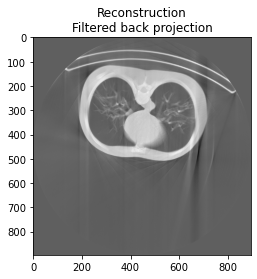

In [24]:
plt.title("Reconstruction\nFiltered back projection")
plt.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
plt.show()

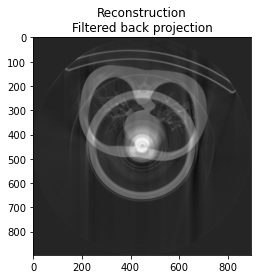

In [33]:
theta = np.linspace(0, 180, 1440, endpoint=False)
reconstruction_fbp = iradon(np.array(sinogram_),theta=theta)#, output_size=128)#, circle=True)
plt.title("Reconstruction\nFiltered back projection")
plt.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
plt.show()

## Further experiment

### Adding shift

In [ ]:
for i in np.asarray(np.linspace(0,2880,10)).astype(int):
    print(i)
    sinogram = create_sinogram_stupid_360(strips,shift=i)
    theta = np.linspace(0, 360, 2880, endpoint=False)
    reconstruction_fbp = iradon(np.array(sinogram),theta=theta, output_size=512)#, circle=True)
    
    plt.figure()
    plt.title("Reconstruction\nFiltered back projection")
    plt.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
    plt.show()

In [ ]:
for s in np.linspace(0,MAX_DISPLACEMENT,HALF_PROJECTIONS):
    for theta in np.linspace(0,HALF_VIEW_ANGLE,HALF_ANGLES):
        alpha=theta-math.asin(s/SMALL_R)
        print(alpha)